## A) Introducción:
#### a) Familiarizarse con la clase BCIDataset del notebook asociado al TP. Estudiar el código en detalle. Estudiar los atributos del objeto y su impacto. Estudiar los atributos generados internamente (“resultados”) en la clase en relación a lo charlado en la presentación del TP.
#### b) Estudiar cómo varía el número de ejemplos en el dataset y la dimensión de cada dato según la variación de la ventana de tiempo seleccionada y el criterio de solapamiento.

In [1]:
from pathlib import Path
import pyforest
import utils
from typing import Callable
import scipy

In [2]:
def filtered_fft_features(signal_matrix):
    N = signal_matrix.shape[1]
    dt = 1/200
    T = N*dt
    sf = 200
    Q = 30
    f_notch = 50
    b_notch, a_notch = sgn.iirnotch(w0=f_notch, Q=Q, fs=sf)
    sig_notch = sgn.filtfilt(b_notch, a_notch, signal_matrix, axis=1)

    #Ahora creamos el filtro pasabanda Butterworth
    f_nq = sf/2
    f_low = 5
    f_high = 40
    order = 4
    b_band, a_band = sgn.iirfilter(
        N=order, Wn=[f_low/f_nq, f_high/f_nq], btype="bandpass", ftype="butter"
    )
    sig_filt = sgn.filtfilt(b_band, a_band, sig_notch, axis=1)

    fft = np.fft.rfft(sig_filt)
    Sxx = np.real(((2*dt**2)/T)*fft*fft.conj())
    return Sxx


def naif_fft_features(signal_matrix):
    N = signal_matrix.shape[1]
    dt = 1/200
    T = N*dt
    fft = np.fft.rfft(signal_matrix)
    Sxx = np.real(((2*dt**2)/T)*fft*fft.conj())
    return Sxx


In [3]:
class BCIDataset():
    def __init__(
        self, csvs_path, subject: str = 'all', session: str = 'all',
        channel: str = 'all', overlapping_fraction: float = 1/3, window_size: int = 900,
        feature_extractor: Callable = naif_fft_features
    ):
        self.csvs_path = Path(csvs_path)
        self.channel = channel
        self.parts = int(1 / overlapping_fraction)
        self.fraction = 1 / self.parts
        self.ws = window_size
        self.subject = subject
        self.session = session
        self.channels = ['ch0','ch1','ch2','ch3']
        self.feature_extractor = feature_extractor
        self.complete_dataset = utils.read_all_datasets(self.csvs_path)
        
        self.complete_examples_signal, self.complete_examples_features, self.complete_labels, self.complete_metadata = \
            self.generate_examples()
        
    def generate_examples(self):
        # For each session generate the signal examples,
        # the feature extraction examples and labels arrays
        complete_examples_signal, complete_examples_features = [], []
        complete_labels, complete_metadata = [], []
        
        for subject in self.complete_dataset.subject.unique():
            # Just load the selected subjects
            if self.subject != 'all' and subject != self.subject:
                continue
            sessions = \
                self.complete_dataset.loc[self.complete_dataset.subject==subject].session.unique()
            for session in sessions:
                selection = self.complete_dataset.loc[
                    (self.complete_dataset.subject==subject) &
                    (self.complete_dataset.session==session)
                ]
                # Just load the selected session
                if self.session != 'all' and session != self.session:
                    continue
                    
                print(f'Processing subject: {subject} - session: {session}...')
                
                # Standarize length of the array to a multiple to window size
                labels = selection.label.values
                n_rows = labels.shape[0] // self.ws
                labels = labels[: n_rows * self.ws]

                # Generate examples from the signal
                n_examples = n_rows * self.parts
                examples = np.empty((n_examples, self.ws))
                most_frec_labels = np.empty((n_examples, self.ws))
                times = np.empty((n_examples, self.ws))
                
                concat_ch_examples_signal, concat_ch_examples_features = [], []

                for k, ch in enumerate(self.channels):
                    # Use the four channels or just one
                    if self.channel != 'all' and self.channel != ch:
                        continue
                    
                    # Standarize length of the signal to a multiple to window size
                    signal = selection[ch].values
                    signal = signal[: n_rows * self.ws]
                    time = selection.time.values
                    time = time[: n_rows * self.ws]

                    # Increase the number of examples by overlapping the windows
                    for part in range(self.parts):
                        
                        # Find the place in the output array for each example
                        position = np.arange(part, n_examples, self.parts)
                        position = position if part == 0 else position[:-part]

                        # Crop the signal according to the window size and overlap
                        start = int(self.ws / self.parts) * part
                        end = -int(self.ws - self.ws / self.parts) * part
                        end = end if end != 0 else signal.shape[0]
                        subset_signal = signal[start:end]
                        subset_labels = labels[start:end]
                        subset_times = time[start:end]

                        # Generate the examples
                        n_rows_ = int(subset_signal.shape[0]/self.ws)
                        examples[position, :] = subset_signal.reshape((n_rows_, self.ws))
                        most_frec_labels[position, :] = subset_labels.reshape((n_rows_, self.ws))
                        times[position, :] = subset_times.reshape((n_rows_, self.ws))
                    
                    # Obtain most frequent label
                    labels_ = scipy.stats.mode(most_frec_labels, axis=1).mode
                    labels_temp = scipy.stats.mode(most_frec_labels, axis=1).count
                    pureness = labels_temp >= self.ws*0.6
                    # Get first and last time of the window
                    times_ = np.asarray([np.min(times, axis=1), np.max(times, axis=1)]).T
                    # Extract features
                    features = self.feature_extractor(examples)

                    concat_ch_examples_signal.append(examples)
                    concat_ch_examples_features.append(features)

                concat_ch_examples_signal = np.concatenate(concat_ch_examples_signal, axis=1)
                concat_ch_examples_features = np.concatenate(concat_ch_examples_features, axis=1)

                complete_examples_signal.append(concat_ch_examples_signal)
                complete_examples_features.append(concat_ch_examples_features)
                complete_labels.append(labels_)
                lt = len(times_)
                metadata_ = np.concatenate(
                    [pureness, times_, np.repeat(subject, lt)[:,None], np.repeat(session, lt)[:,None]],
                    axis=1
                )
                complete_metadata.append(metadata_)

        complete_examples_signal = np.concatenate(complete_examples_signal)
        complete_examples_features = np.concatenate(complete_examples_features)
        complete_labels = np.concatenate(complete_labels)
        complete_metadata = np.concatenate(complete_metadata)
        
        return complete_examples_signal, complete_examples_features, complete_labels, complete_metadata
    
    def __len__(self):
        return self.complete_examples_signal.shape[0]
    
    def __getitem__(self, idx):
        return {
            'signal': self.complete_examples_signal[idx,:],
            'features': self.complete_examples_features[idx,:],
            'label': self.complete_labels[idx,:],
            'metadata': self.complete_metadata[idx,:]
        }

    def get_X_signal(self):
        return self.complete_examples_signal

    def get_X_features(self):
        return self.complete_examples_features

    def get_Y(self):
        return self.complete_labels

    def get_metadata(self):
        return self.complete_metadata



In [4]:
csvs_path = '/home/ariel/gabriel/diplo_de_datos/mentoria_BCI/tp3'
dataset = BCIDataset(csvs_path, subject='AA', session='0')

Processing subject: AA - session: 0...


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [5]:
metadata = pd.DataFrame(dataset.complete_metadata, columns = ['purness', 't_start', 't_end', 'subject', 'session'])

<IPython.core.display.Javascript object>

In [6]:
metadata
#me devuelve la matriz de metadata generada por purness (pureza, t_start y t_end son el tiempo de inicio y de fin
#del ejemplo, el subject del cual fue extraido el ejemplo y su sesion)

,purness,t_start,t_end,subject,session
0,True,0.0,4.495,AA,0
1,True,1.5,5.995,AA,0
2,True,3.0,7.495,AA,0
3,True,4.5,8.995,AA,0
4,True,6.0,10.495,AA,0
...,...,...,...,...,...
148,False,222.0,226.495,AA,0
149,False,1704.02,1921.94,AA,0
150,True,225.0,229.495,AA,0
151,False,1718.12,1916.77,AA,0


In [7]:
metadata.purness.value_counts()
#son False los valores impuros que contengan mas de una etiqueta 

True     119
False     34
Name: purness, dtype: int64

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

(0.0, 6.0)

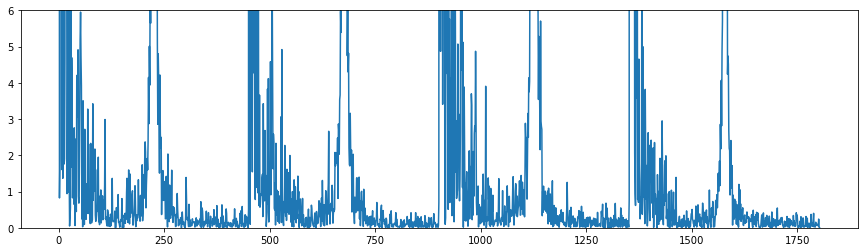

In [8]:
plt.figure(figsize=(15,4))
plt.plot(dataset.complete_examples_features[2,:])
plt.ylim([0,6])
# plt.xlim([8,40])


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

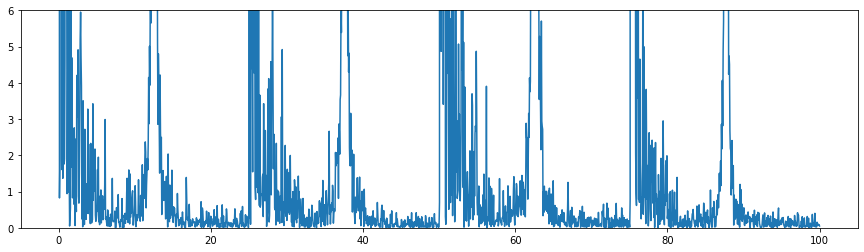

In [9]:
#grafico las frecuencias
N=dataset.complete_examples_signal.shape[1]
dt = 1/200
freqs = np.fft.rfftfreq(n=N, d=dt)

plt.figure(figsize=(15,4))
plt.ylim([0,6])
plt.plot(freqs,dataset.complete_examples_features[2,:1801])

In [11]:
print('dimension matriz senal ', dataset.get_X_signal().shape)
print('dimension matriz features ', dataset.get_X_features().shape)

#devuelve una matriz donde en cada fila tengo cada ejemplo y en las columnas las features extraidas

dimension matriz senal  (153, 3600)
dimension matriz features  (153, 1804)


In [12]:
dataset.get_Y().shape
#devuelve el vector target

(153, 1)

In [13]:
dataset.__getitem__(0)
#me devuelve el valor de un ejemplo

{'signal': array([-41.36, -15.13,  32.23, ...,  16.48, -32.06, -62.72]),
 'features': array([2.38843219e+04, 6.95994694e+01, 1.14199542e+01, ...,
        1.18164148e-01, 9.98628650e-02, 4.53153361e-01]),
 'label': array([99.]),
 'metadata': array(['True', '0.0', '4.495', 'AA', '0'], dtype='<U32')}

In [19]:
#pruebo modificando la dimensin del solapamiento
dataset_of1 = BCIDataset(csvs_path, subject='AA', session='0',overlapping_fraction=1/2)
dataset_of1.get_X_features().shape
#disminuye la cantidad de ejemplos al aumentar el solapamiento

Processing subject: AA - session: 0...


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

(102, 1804)

In [20]:
#pruebo modificando la dimensin del solapamiento
dataset_of2 = BCIDataset(csvs_path, subject='AA', session='0',overlapping_fraction=1/4)
dataset_of2.get_X_features().shape
#aumenta la cantidad de ejemplos al disminuir el solapamiento

Processing subject: AA - session: 0...


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

(204, 1804)

## B) Características Temporales:
#### a) Usando BCIDataset junto con el extractor de features básico de fft (“naif_fft_features”), analice la influencia que tiene el tamaño de la ventana en el dominio de tiempo en la resolución en frecuencia del espectrograma de potencia.

In [14]:
#pruebo modificando la dimensin de la ventana
dataset_ws1 = BCIDataset(csvs_path, subject='AA', session='0',window_size=600)
#el window size tal como esta la clase tiene que ser multiplo de 3 

Processing subject: AA - session: 0...


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [15]:
dataset_ws1.get_X_features().shape
#aumenta la cantidad de ejemplos pero disminuye cant de features

(228, 1204)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

(0.0, 6.0)

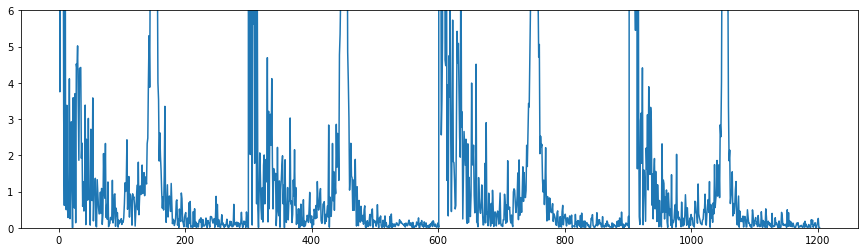

In [16]:
#pruebo graficar para ver modificacion de resolucion
plt.figure(figsize=(15,4))
plt.plot(dataset_ws1.complete_examples_features[2,:])
plt.ylim([0,6])
#disminuye la resolucion al tener menos datos en el eje x?

In [17]:
#pruebo modificando la dimensin de la ventana
dataset_ws2 = BCIDataset(csvs_path, subject='AA', session='0',window_size=1200)
#el window size tal como esta la clase tiene que ser multiplo de 3 
dataset_ws2.get_X_features().shape
#disminuye la cantidad de ejemplos pero aumentan cant de features

Processing subject: AA - session: 0...


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

(114, 2404)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

(0.0, 6.0)

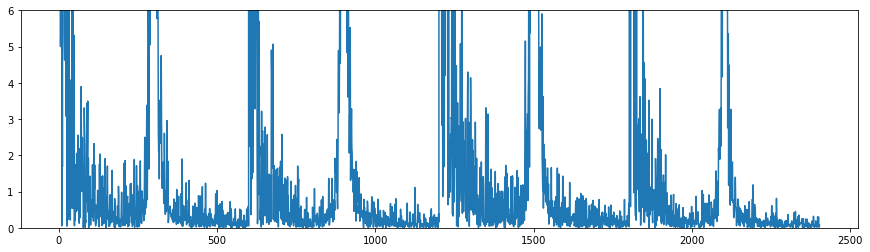

In [18]:
plt.figure(figsize=(15,4))
plt.plot(dataset_ws2.complete_examples_features[2,:])
plt.ylim([0,6])
# plt.xlim([8,40])

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

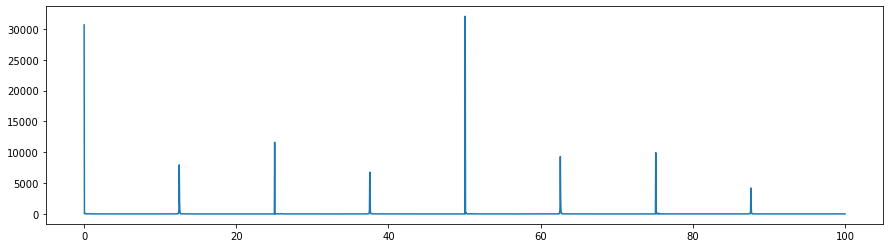

In [33]:
N=dataset_ws2.complete_examples_signal.shape[1]
dt = 1/200
freqs = np.fft.rfftfreq(n=N, d=dt)

plt.figure(figsize=(15,4))
#plt.ylim([0,6])
plt.plot(freqs,dataset_ws2.complete_examples_features[2,:2401])

In [23]:
#pruebo modificando la dimensin de la ventana tal que sea menor a 200 features
dataset_ws3 = BCIDataset(csvs_path, subject='AA', session='0',window_size=90)
#el window size tal como esta la clase tiene que ser multiplo de 3 
dataset_ws3.get_X_features().shape

Processing subject: AA - session: 0...


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

(1530, 184)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

(0.0, 6.0)

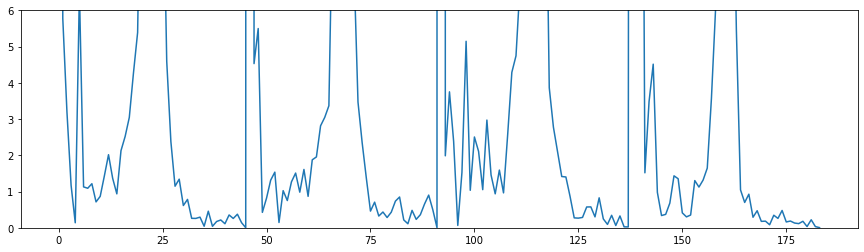

In [30]:
plt.figure(figsize=(15,4))
plt.plot(dataset_ws3.complete_examples_features[2,:])
plt.ylim([0,6])
# plt.xlim([8,40])

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

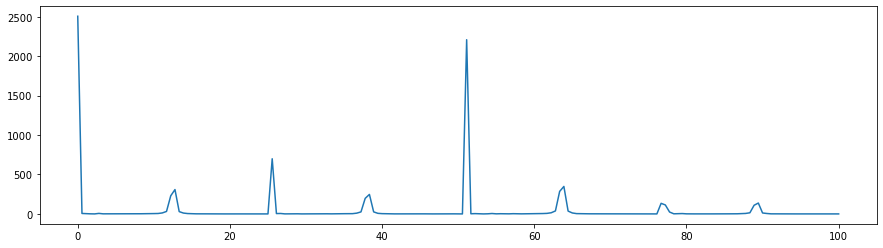

In [27]:
N=dataset_ws3.complete_examples_signal.shape[1]
dt = 1/200
freqs = np.fft.rfftfreq(n=N, d=dt)

plt.figure(figsize=(15,4))
#plt.ylim([0,6])
plt.plot(freqs,dataset_ws3.complete_examples_features[2,:181])

#### b) Teniendo en cuenta el inciso anterior, las frecuencias de estimulación y la frecuencia de muestreo pertinentes, ¿cuál considera que es el número adecuado de muestras temporales que puede recortar conservando la mayor cantidad de información útil en el dominio de la frecuencia? (t).

#### c) En adición a la serie temporal cruda -”complete_examples_signal”- (concatenada o no a lo largo de los canales, según su elección), defina una estrategia de extracción de atributos en el dominio de tiempo que opere sobre la serie cruda, ejemplo: algún criterio como la media en cada canal para el ejemplo. Sean creativos pero no dediquen mucho tiempo a este inciso, es más bien para tener un punto de comparación.

In [37]:
from tsfel.feature_extraction import features
#pruebo usando esta libreria que nos puede ahorrar trabajo de computo
#https://tsfel.readthedocs.io/en/latest/descriptions/feature_list.html

In [41]:
features.calc_max(dataset.get_X_signal())

100.82

In [97]:
#maximo de cada ejemplo en su valor absoluto? o simple?
max_signal=[]
for i in dataset.get_X_signal():
    max_signal.append(features.calc_max(i))

In [99]:
max_signal

[59.59,
 59.59,
 49.24,
 66.83,
 66.83,
 66.83,
 30.27,
 31.71,
 31.71,
 55.31,
 68.68,
 68.68,
 75.63,
 100.82,
 100.82,
 100.82,
 76.64,
 76.64,
 76.64,
 75.07,
 60.12,
 60.12,
 96.46,
 96.46,
 96.46,
 61.41,
 61.41,
 61.41,
 56.0,
 54.68,
 54.68,
 56.91,
 56.91,
 56.91,
 54.94,
 54.94,
 62.54,
 62.54,
 62.54,
 46.86,
 46.86,
 46.86,
 42.84,
 39.51,
 49.06,
 49.06,
 49.06,
 35.93,
 44.61,
 44.61,
 52.08,
 68.81,
 68.81,
 68.81,
 67.63,
 35.31,
 42.99,
 48.96,
 61.93,
 61.93,
 61.93,
 73.66,
 73.66,
 73.66,
 61.96,
 47.84,
 33.26,
 40.22,
 40.22,
 40.22,
 40.68,
 40.68,
 40.68,
 29.95,
 35.88,
 35.88,
 35.88,
 35.75,
 34.42,
 47.88,
 47.88,
 47.88,
 34.62,
 38.88,
 38.88,
 38.88,
 38.19,
 42.14,
 42.14,
 42.14,
 35.36,
 32.97,
 63.73,
 63.73,
 63.73,
 52.95,
 50.21,
 50.21,
 50.21,
 44.2,
 49.02,
 49.02,
 49.02,
 32.79,
 28.65,
 28.65,
 28.55,
 28.55,
 31.62,
 69.79,
 69.79,
 69.79,
 66.86,
 51.58,
 51.58,
 51.58,
 48.08,
 54.52,
 54.52,
 54.52,
 41.61,
 30.14,
 40.1,
 40.1,
 40.1,
 3

In [67]:
#hay algunos ejemplos que hay que descartar al ser nulos? 
dataset[151]

{'signal': array([0., 0., 0., ..., 0., 0., 0.]),
 'features': array([0., 0., 0., ..., 0., 0., 0.]),
 'label': array([-30.3]),
 'metadata': array(['False', '1718.12', '1916.77', 'AA', '0'], dtype='<U32')}

In [100]:
#minimo de cada ejemplo
min_signal=[]
for i in dataset.get_X_signal():
    min_signal.append(features.calc_min(i))

In [101]:
#la media
mean_signal=[]
for i in dataset.get_X_signal():
    mean_signal.append(features.calc_mean(i))

In [102]:
#la mediana
median_signal=[]
for i in dataset.get_X_signal():
    median_signal.append(features.calc_median(i))

In [103]:
#desviacion estandar
std_signal=[]
for i in dataset.get_X_signal():
    std_signal.append(features.calc_std(i))

In [104]:
#devuelve la energia total de cada senal
energy_signal=[]
for i in dataset.get_X_signal():
    energy_signal.append(features.total_energy(i,200))

In [105]:
#devuelve el area bajo la curva de la senal
auc_signal=[]
for i in dataset.get_X_signal():
    auc_signal.append(features.auc(i,200))

In [106]:
#me devuelve la frecuencia fundamental
fundamental_frequency=[]
for i in dataset.get_X_signal():
    fundamental_frequency.append(features.fundamental_frequency(i,200))
#al no estar filtrada la senal la mayoria es 50 hz 

#### d) Guarde los datasets generados de la forma que considere conveniente.

In [124]:
max_signal = pd.DataFrame(max_signal,columns=['max_signal'])
min_signal = pd.DataFrame(min_signal,columns=['min_signal'])
mean_signal = pd.DataFrame(mean_signal,columns=['mean_signal'])
median_signal = pd.DataFrame(median_signal,columns=['median_signal'])
std_signal = pd.DataFrame(std_signal,columns=['std_signal'])
energy_signal = pd.DataFrame(energy_signal,columns=['energy_signal'])
auc_signal = pd.DataFrame(auc_signal,columns=['auc_signal'])
features=[mean_signal,median_signal,std_signal,energy_signal,auc_signal]

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [125]:
time_features = max_signal.merge(min_signal,left_index=True,right_index=True)
time_features
#realizo el merge de los df

,max_signal,min_signal
0,59.59,-124.92
1,59.59,-95.23
2,49.24,-95.23
3,66.83,-118.50
4,66.83,-118.50
...,...,...
148,55.63,-86.53
149,0.00,0.00
150,55.63,-101.10
151,0.00,0.00


In [126]:
for i in features:
    time_features = time_features.merge(i,left_index=True,right_index=True)

In [127]:
time_features

,max_signal,min_signal,mean_signal,median_signal,std_signal,energy_signal,auc_signal
0,59.59,-124.92,-33.061233,-35.715,37.925512,506418.591453,689.619400
1,59.59,-95.23,-28.723044,-30.555,33.633848,391358.515721,587.690475
2,49.24,-95.23,-26.923622,-26.885,32.399901,355025.621784,544.827200
3,66.83,-118.50,-26.535544,-21.445,35.777792,396947.366246,549.608800
4,66.83,-118.50,-30.647411,-23.870,37.721137,472560.858083,610.181350
...,...,...,...,...,...,...,...
148,55.63,-86.53,-17.798700,-19.820,35.859943,320634.918522,453.945150
149,0.00,0.00,0.000000,0.000,0.000000,0.000000,0.000000
150,55.63,-101.10,-21.576600,-31.230,38.725264,393148.362456,542.391900
151,0.00,0.00,0.000000,0.000,0.000000,0.000000,0.000000


#### e) Para cada dataset, analice la contribución de información de cada feature estudiado al propósito de clasificación. Estudie la correlación entre features. Estudie la correlación entre features y etiquetas. En conjunto con la exploración de los TP anteriores, ¿considera útil estos atributos?

In [131]:
labels = pd.DataFrame(dataset.complete_labels,columns=['labels'])

<IPython.core.display.Javascript object>

In [134]:
time_features_labels = time_features.merge(labels,left_index=True,right_index=True)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

,max_signal,min_signal,mean_signal,median_signal,std_signal,energy_signal,auc_signal,labels
max_signal,1.000000,-0.482869,0.193221,0.182248,0.688865,0.214003,0.218854,0.295072
min_signal,-0.482869,1.000000,0.585716,0.631748,-0.822604,-0.825172,-0.827742,-0.205207
mean_signal,0.193221,0.585716,1.000000,0.916621,-0.393410,-0.874813,-0.883313,0.022332
median_signal,0.182248,0.631748,0.916621,1.000000,-0.388392,-0.818233,-0.820660,-0.037658
std_signal,0.688865,-0.822604,-0.393410,-0.388392,1.000000,0.695768,0.743577,0.177319
energy_signal,0.214003,-0.825172,-0.874813,-0.818233,0.695768,1.000000,0.972988,0.112021
auc_signal,0.218854,-0.827742,-0.883313,-0.820660,0.743577,0.972988,1.000000,0.081590
labels,0.295072,-0.205207,0.022332,-0.037658,0.177319,0.112021,0.081590,1.000000


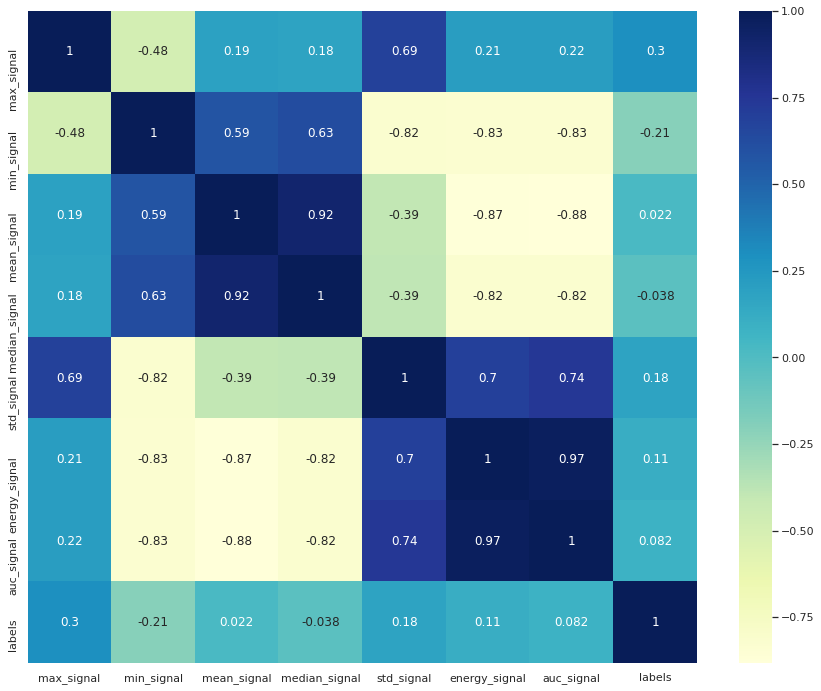

In [136]:
#veo correlacion entre los features
corr_col=time_features_labels.corr()
#.corr es una funcion que correlaciona las variables una con otra y luego la grafico con el heatmap de seaborn
sns.heatmap(corr_col, cmap="YlGnBu", annot = True)
sns.set(rc={'figure.figsize':(15,12)})
corr_col
#se ve correlacion entre features pero no entre los features y los labels